# Pytorch Lightning Framework for training S+Z Galaxy Classifiers

## Imports

In [10]:
import os
from enum import Enum
import pandas as pd
import torch
from torch.utils.data import random_split
import lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger,CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import albumentations as A
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule
from ChiralityClassifier import ChiralityClassifier

## Options

In [11]:
class modes(Enum):
    FULL_DATASET = 0 #Use all 600,000 galaxies
    CUT_DATASET = 1 #Use cut of 200,000 galaxies, with pre-selected test data and downsampled train data
    BEST_SUBSET = 2 #Select N best S,Z & other galaxies, evenly split
    LOCAL_SUBSET = 3 #Use local cache of 1500 galaxies

IMG_SIZE = 160 # This is the output size of the generated image array
MODE = modes.CUT_DATASET
RUN_TEST = False #Run on testing dataset & save metrics
# Models:
#resnet18,resnet34,resnet50,resnet101,resnet152,
#jiaresnet50,LeNet,
#G_ResNet18,G_LeNet,
MODEL_NAME = 'resnet18'
CUSTOM_ID = '2'
USE_TENSORBOARD = False

MODEL_SAVE_PATH = "../Models"
GRAPH_SAVE_PATH = "../Graphs"
LOG_PATH = "../Code/lightning_logs" #lightning_logs
FULL_DATA_PATH = '/share/nas2/walml/galaxy_zoo/decals/dr8/jpg'
LOCAL_SUBSET_DATA_PATH = '../Data/Subset'

FULL_CATALOG_PATH = '../Data/gz1_desi_cross_cat.csv'
CUT_CATALOG_TEST_PATH = '../Data/gz1_desi_cross_cat_testing.csv'
CUT_CATALOG_TRAIN_PATH = '../Data/gz1_desi_cross_cat_train_val_downsample.csv'
BEST_SUBSET_CATALOG_PATH = '../Data/gz1_desi_cross_cat_best_subset.csv'
LOCAL_SUBSET_CATALOG_PATH = '../Data/gz1_desi_cross_cat_local_subset.csv'

torch.set_float32_matmul_precision("medium")
MODEL_ID = f"{MODEL_NAME}_{MODE.name.lower()}_{CUSTOM_ID}"

## GPU Test

In [12]:
print(f"Using pytorch {torch.__version__}. CPU cores available on device: {os.cpu_count()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print(f'Allocated Memory: {round(torch.cuda.memory_allocated(0)/1024**3,1)} GB')
    print(f'Cached Memory: {round(torch.cuda.memory_reserved(0)/1024**3,1)} GB')
print('Using device:', device)

Using pytorch 2.2.1. CPU cores available on device: 24
NVIDIA A100-PCIE-40GB
Allocated Memory: 0.0 GB
Cached Memory: 0.0 GB
Using device: cuda


## Reading in data

### Building catalog

In [13]:
def get_file_paths(catalog_to_convert,folder_path):
    brick_ids = catalog_to_convert['dr8_id'].str.split("_",expand=True)[0]
    dr8_ids = catalog_to_convert['dr8_id']
    file_locations = folder_path+'/'+brick_ids+'/'+dr8_ids+'.jpg'
    print(f"Created {file_locations.shape[0]} galaxy filepaths")
    return file_locations

def generate_transforms(resize_after_crop=IMG_SIZE):
    transforms_to_apply = [
        A.ToFloat(), #Converts from 0-255 to 0-1

        A.Resize( #Resizes to 160x160
            height=resize_after_crop,
            width=resize_after_crop,
            interpolation=1,
            always_apply=True
        ),

        #A.randomrotate
    ]
    return A.Compose(transforms_to_apply)

In [14]:
if MODE == modes.CUT_DATASET:
    train_val_catalog = pd.read_csv(CUT_CATALOG_TRAIN_PATH)
    train_val_catalog['file_loc'] = get_file_paths(train_val_catalog,FULL_DATA_PATH)
    generator1 = torch.Generator().manual_seed(42) #Preset test-val split, note test dataloader will still shuffle
    train_catalog, val_catalog = random_split(train_val_catalog, [0.20,0.80], generator=generator1)
    train_catalog = train_catalog.dataset.iloc[train_catalog.indices]
    val_catalog = val_catalog.dataset.iloc[val_catalog.indices]   
    test_catalog = pd.read_csv(CUT_CATALOG_TEST_PATH)
    test_catalog['file_loc'] = get_file_paths(test_catalog,FULL_DATA_PATH)

    datamodule = GalaxyDataModule(
        label_cols=['P_CW','P_ACW','P_OTHER'],
        train_catalog=train_catalog, val_catalog=train_catalog, test_catalog=test_catalog,
        custom_albumentation_transform=generate_transforms(),
        batch_size=200,
        num_workers=11,
    )
    
else:
    if MODE == modes.FULL_DATASET:
        catalog = pd.read_csv(FULL_CATALOG_PATH)
        catalog['file_loc'] = get_file_paths(catalog,FULL_DATA_PATH)

    elif MODE == modes.BEST_SUBSET:
        catalog = pd.read_csv(BEST_SUBSET_CATALOG_PATH)
        catalog['file_loc'] = get_file_paths(catalog,FULL_DATA_PATH)

    elif MODE == modes.LOCAL_SUBSET:
        catalog = pd.read_csv(LOCAL_SUBSET_CATALOG_PATH)
        catalog['file_loc'] = get_file_paths(catalog,LOCAL_SUBSET_DATA_PATH)

    datamodule = GalaxyDataModule(
        label_cols=['P_CW','P_ACW','P_OTHER'],
        catalog=catalog,
        train_fraction=0.7, val_fraction=0.15, test_fraction=0.15,
        custom_albumentation_transform=generate_transforms(),
        batch_size=100,
        num_workers=11,
    )

Created 35988 galaxy filepaths
Created 41737 galaxy filepaths


## Code to run

In [15]:
datamodule.prepare_data()
datamodule.setup()

In [16]:
model = ChiralityClassifier(
    num_classes=(2 if (MODEL_NAME=="jiaresnet50") else 3), #2 for Jia et al version
    model_version=MODEL_NAME,
    optimizer="adamw",
    scheduler  ="steplr",
    lr=0.0001,
    weight_decay=0,
    step_size=5,
    gamma=0.85,
    batch_size=60,
    weights=None,
    model_save_path=f"{MODEL_SAVE_PATH}/{MODEL_ID}.pt",
    graph_save_path=f"{GRAPH_SAVE_PATH}/{MODEL_ID}_matrix.png"
)

#stopping_callback = EarlyStopping(monitor="val_loss", mode="min")

tb_logger = TensorBoardLogger(LOG_PATH, name=MODEL_ID,version=0)
csv_logger = CSVLogger(LOG_PATH,name=MODEL_ID,version=0)

trainer = pl.Trainer(
    accelerator=("gpu" if device.type=="cuda" else "cpu"),
    max_epochs=60,
    devices=1,
    logger=([tb_logger,csv_logger] if USE_TENSORBOARD else csv_logger),
    default_root_dir=f'{LOG_PATH}/{MODEL_ID}',
    profiler="pytorch"
    #callbacks=[stopping_callback]
)

/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning_fabric/loggers/csv_logs.py:186: UserWarning: Experiment logs directory ../Code/lightning_logs/resnet18_cut_dataset_2/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | model   | ResNet           | 11.2 M
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

STAGE:2024-03-12 11:52:13 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  11%|█         | 4/36 [00:04<00:34,  1.09s/it, v_num=0, train_loss_step=1.020, train_acc_step=0.545, train_calibration_error_step=0.058] 

STAGE:2024-03-12 11:52:17 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 11:52:17 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:602] Warning: Optimizer.step#AdamW.step (function operator())
[W collection.cpp:602] Warning: [pl][profile][LightningModule]ChiralityClassifier.optimizer_step (function operator())


Epoch 0: 100%|██████████| 36/36 [00:09<00:00,  3.62it/s, v_num=0, train_loss_step=0.886, train_acc_step=0.652, train_calibration_error_step=0.0697] 

STAGE:2024-03-12 11:52:25 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-12 11:52:25 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 11:52:25 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 9: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s, v_num=0, train_loss_step=0.523, train_acc_step=0.949, train_calibration_error_step=0.187, val_acc=0.906, val_calibration_error=0.130, train_loss_epoch=0.550, train_acc_epoch=0.924, train_calibration_error_epoch=0.166]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s, v_num=0, train_loss_step=0.523, train_acc_step=0.949, train_calibration_error_step=0.187, val_acc=0.906, val_calibration_error=0.130, train_loss_epoch=0.550, train_acc_epoch=0.924, train_calibration_error_epoch=0.166]


FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         2.25%       4.174ms        99.95%     185.281ms      92.641ms       0.000us         0.00%      66.159ms      33.080ms             2  
                [pl][profile][_EvaluationLoop].val_next         0.15%     274.000us        49.69%      92.110ms      46.055ms       0.000us         0.00%       

Testing DataLoader 0:  11%|█         | 4/36 [00:00<00:02, 14.91it/s]

STAGE:2024-03-12 11:54:52 46460:46460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-12 11:54:52 46460:46460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-12 11:54:52 46460:46460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Testing DataLoader 0: 100%|██████████| 36/36 [00:05<00:00,  7.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9058071970939636     │
│  test_calibration_error   │    0.1300395429134369     │
│         test_loss         │    0.5660092234611511     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         2.16%       3.908ms        99.85%     180.424ms      60.141ms       0.000us         0.00%     148.388ms      49.463ms             3  
[pl][profile][Strategy]SingleDeviceStrategy.test_ste...         4.80%       8.682ms        93.77%     169.438ms      56.479ms       0.000us         0.00%     1

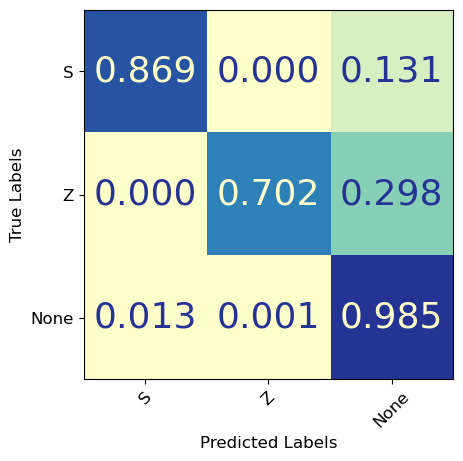

In [17]:
#compiled_model = torch.compile(model, backend="eager")
trainer.fit(model,train_dataloaders=datamodule.train_dataloader(),val_dataloaders=datamodule.val_dataloader() )

if RUN_TEST:
    trainer.test(model,dataloaders=datamodule.test_dataloader())
else:
    trainer.test(model,dataloaders=datamodule.val_dataloader())
    
torch.save(trainer.model.state_dict(), model.model_save_path)